In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
import pickle
import seaborn as sns
import multiprocessing

In [2]:
from joblib import parallel_backend
import warnings
from sklearn.exceptions import ConvergenceWarning
import time
import re

In [21]:
# dask cluster location
cluster_loc = 'hpc'
prefix = 'plot'
tuneby = 'pasture'
logo_group = 'Pasture'
use_cuda = False
# set backend as one of 'multiprocessing' or 'dask'
backend = 'dask' 

inDIR = '../data/extractions/'
inFILE = '2023-2021_RobertsRanch-ResidualEstimates_USDA-ARS_hls_20231115.csv'
nickname = 'rr_snaplands'

inPATH = os.path.join(inDIR, inFILE)

lr_mod = pickle.load(open("/project/cper_neon_aop/cper_hls_veg_models/models/biomass/CPER_HLS_to_VOR_biomass_model_lr_simp.pk", 'rb'))

outDIR = '../data/modeling/'

outFILE_tmp = os.path.join(outDIR, 'tmp', nickname + '_cv_' + logo_group + '_tuneby_' + tuneby + '_tmp.csv')

# unique ID column name
id_col = 'SiteID'
# date column name
date_col = 'Date'
# dependent variable column
y_col = 'biomass_lb_ac'

# apply transformation to dependent variable
y_col_xfrm = False
def y_col_xfrm_func(x):
    return(x*10)

# apply transformation to the output of the CPER (2022) model
cper_mod_xfrm = True
def cper_mod_xfrm_func(x):
    # convert from kg/ha to lbs/acre
    return(x * 0.892179122)

var_names = [
    'NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7', 'SAVI',
    'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI', 'TCGI', 'TCWI',
    'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246', 'BAI_346',
    'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2'
]

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'SAVI': 'savi',
    'RDVI': 'rdvi',
    'MTVI1': 'mtvi1', 
    'NCI': 'nci', 
    'NDCI': 'ndci',
    'PSRI': 'psri',
    'NDWI': 'ndwi',
    'EVI': 'evi',
    'TCBI': 'tcbi',
    'TCGI': 'tcgi',
    'TCWI': 'tcwi',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'BLUE': 'blue',
    'GREEN': 'green',
    'RED': 'red',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

if prefix == 'transect':
    batch_size = 256
elif prefix == 'plot':
    batch_size = 64

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
#from xgboost import XGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim
import skorch
from skorch import NeuralNetRegressor

import sys
sys.path.insert(1, '../extract')
from hpc_setup import launch_dask
from dnn_setup import ResNetRegressor, ResidualBlock

if backend == 'dask':
    #from dask_ml.xgboost import XGBRegressor
    from dask_ml.model_selection import GridSearchCV
    from sklearn.model_selection import GridSearchCV as skGridSearchCV
else:
    #from xgboost import XGBRegressor
    from sklearn.model_selection import GridSearchCV


In [5]:
def vip(x, y, model):
    t = model.x_scores_
    #w = model.x_weights_
    w = model.x_rotations_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

def r2_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    return R_sq

if backend == 'dask':
    import dask
    @dask.delayed
    def fit_ols(all_x, split_groups, df_train, lr_form, group_k, idx):
        r2_adj_tmp = []
        aic_tmp = []
        mae_orig_tmp = []
        for train_index_sub, test_index_sub in mod_logo.split(all_x, groups=split_groups):
            df_train_sub = df_train.iloc[train_index_sub]
            df_test_sub = df_train.iloc[test_index_sub]
            lreg_k_tmp = smf.ols(formula=lr_form, data=df_train_sub).fit()
            r2_adj_tmp.append(lreg_k_tmp.rsquared_adj)
            aic_tmp.append(lreg_k_tmp.aic)
            mae_orig_tmp.append(np.nanmean(np.abs(lreg_k_tmp.predict(df_test_sub) - df_test_sub[y_col])))
        df_results_tmp = pd.DataFrame(dict(group=[group_k],
                                           group_name=[logo_group],
                                           numb_vars=[k_fold],
                                           formula=[lr_form],
                                           R2_adj=round(np.mean(r2_adj_tmp), 4),
                                           AIC=round(np.mean(aic_tmp), 4),
                                           mae_orig_mean=round(np.mean(mae_orig_tmp), 4)),
                                     index=[idx])
        return df_results_tmp

    @dask.delayed
    def fit_dnn(mod_base, batch_start, batch_size, all_x, all_y, loss_fn, optimizer):
        for start in batch_start:
            # take a batch
            X_batch = all_x[start:start+mod_dict[k]['batch_size']]
            y_batch = all_y[start:start+mod_dict[k]['batch_size']]
            # forward pass
            y_pred = mod_base(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
        return mod_base

In [6]:
if backend == 'dask':
    num_jobs=16
    client = launch_dask(cluster_loc=cluster_loc, num_jobs=num_jobs, slurm_opts={'interface': 'ens7f0'})
    nthreads = len(client.nthreads())
    display(client)
else:
    nthreads = multiprocessing.cpu_count()
print(nthreads)

   setting up cluster on HPC...


<Client: 'tcp://10.1.5.188:41097' processes=32 threads=64, memory=149.12 GiB>

32


In [7]:
if torch.has_cuda and use_cuda:
    device='cuda'
    print(torch.cuda.device_count())
else:
    device='cpu'
print(device)

cpu


In [8]:
rnr = NeuralNetRegressor(
    ResNetRegressor(ResidualBlock, layers=[3, 4, 6, 3], n_inputs=len(var_names)),
    criterion=nn.L1Loss,
    optimizer=optim.SGD,
    lr=0.001,
    max_epochs=100,
    batch_size=128,
    train_split=skorch.dataset.ValidSplit(0.2),
    callbacks=[skorch.callbacks.EarlyStopping(patience=10, load_best=True)],
    verbose=0, 
    device=device
)

In [22]:
mod_dict = {
    'CPER_2022': {
        'base_mod': lr_mod,
        'fit': True,
        'tune': False,
        'tune_refit': None,
        'tune_refit_type': None,
        'variable_importance': False,
        'scale_x': False,
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
    },
    'OLS_2022': {
        'base_mod': y_col + ' ~ NDII7 + NIR1 + BAI_236 + NDII7:NIR1 + NDII7:BAI_236 + NIR1:BAI_236',
        'fit': True,
        'tune': True,
        'tune_refit': 'mae_orig_mean',
        'tune_refit_type': 'minimize',
        'variable_importance': False,
        'scale_x': False,
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
    },
    'OLS': {
        'base_mod': y_col + ' ~ ',
        'fit': True,
        'tune': True,
        'tune_refit': 'mae_orig_mean',
        'tune_refit_type': 'minimize',
        'variable_importance': False,
        'scale_x': False,
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'formula_df': pd.DataFrame(columns=['group', 'group_name', 'numb_vars', 'formula', 'R2_adj', 'AIC', 'mae_orig_mean'])
    },
    'LASSO': {
        'base_mod': Lasso(),
        'fit': True,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'alpha': np.logspace(-3, 1, num=30)
        },
        'tune_results': {},
        'scale_x': True,
        'scaler': StandardScaler(),
        'log_y': True,
        'interactions': True,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'Coef'])
    },
    'PLS': {
        'base_mod': PLSRegression(n_components=1, scale=False),
        'fit': True,
        'tune': True,
        'tune_vip': False,
        'tune_vip_iters': 3,
        'tune_vip_thresh': [0.8, 0.8, 0.8],
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'n_components': [int(x) for x in np.arange(1, len(var_names)*0.5)]
        },
        'tune_results': {},
        'scale_x': True,
        'scaler': StandardScaler(),
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'VIP', 'Coef'])
    },
    'PCR': {
        'base_mod': Pipeline(
            [
                ('scaler', StandardScaler()), 
                ('pca', PCA()), 
                ('linreg', LinearRegression())
            ]),
        'fit': True,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'pca__n_components': [int(x) for x in np.arange(1, len(var_names)*0.5)]
        },
        'tune_results': {},
        'scale_x': False,
        'scaler': StandardScaler(),
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable'] + ['PC_' + str(i+1) for i in range(len(var_names))])
    },
    'SVR': {
        'base_mod': SVR(kernel='linear'),
        'fit': True,
        'variable_importance': True,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'C': np.logspace(1.5, 4, 10, base=10),
            'gamma': np.logspace(-3.5, 0, 10, base=10)
        },
        'tune_results': {},
        'scale_x': True,
        'scaler': StandardScaler(),
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'PI'])
    },
    'RF': {
        'base_mod': RandomForestRegressor(n_estimators=200, bootstrap=True, oob_score=True, n_jobs=-1),
        'fit': True,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'min_samples_split': [0.0001, 0.001, 0.005, 0.01],
            #'n_estimators': [400],
            'max_samples': [0.2, 0.3, 0.5, 0.7, 0.9],
            'max_features': [0.1, 0.25, 0.5, 0.75, 1.0]
        },
        'tune_results': {},
        'scale_x': True,
        'scaler': StandardScaler(),
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'PI'])
    },
    'GBR': {
        #'base_mod': XGBRegressor(n_jobs=-1, verbosity=0),
        'base_mod': Pipeline(
            [
                ('scaler', StandardScaler()), 
                ('gbr', GradientBoostingRegressor(loss='absolute_error'))
            ]),
        'fit': True,
        'variable_importance': True,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'gbr__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
            'gbr__min_samples_split': [0.001, 0.005, 0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
            'gbr__n_estimators': [100, 200, 400, 600, 800],
            'gbr__max_features': [0.1, 0.25, 0.5]
        },
        'tune_results': {},
        'scale_x': False,
        'scaler': StandardScaler(),
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'PI'])
    },
    'MLP': {
        'base_mod': MLPRegressor(solver='adam', activation='logistic', hidden_layer_sizes=(256,),
                                 max_iter=1000, learning_rate='adaptive'),
        'fit': False,
        'variable_importance': False,
        'tune': False,
        'tune_refit': 'MAPE',
        'param_grid': {
            'hidden_layer_sizes': [(50,), (100,), (150,)],
            'alpha': [0.00005, 0.0001, 0.0005, 0.001]
        },
        'tune_results': {},
        'scale_x': True,
        'scaler': StandardScaler(),
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame()
    },
    'DNN': {
        'base_mod': rnr,
        'fit': False,
        'variable_importance': False,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'module__block': [ResidualBlock],
            'module__layers': [[3, 4, 6, 3]], 
            'module__n_inputs': [len(var_names)],
            'optimizer__momentum': [0.75, 0.85, 0.95],
            'optimizer__weight_decay': [1e-2, 1e-4],
            'optimizer__nesterov': [True],
            'lr': [0.01, 0.001, 0.0001],
            'batch_size': [batch_size],
            'max_epochs': [100],
        },
        'tune_results': {},
        'scale_x': True,
        'scaler': MinMaxScaler(),
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame()
}
}

In [23]:
df = pd.read_csv(inPATH, parse_dates=[date_col])

In [24]:
df['Year'] = df['Date'].dt.year

In [25]:
# check for any missing data
len(df[df[var_names].isnull().any(axis=1)])

0

In [26]:
# remove missing data
df = df[~df[var_names].isnull().any(axis=1)].copy()

In [27]:
df.head(5)

,SiteID,Pasture,Date,Year,Season,biomass_lb_ac,biomass_kg_ha,Lat,Long,_geometry,...,BAI_146,BAI_236,BAI_246,BAI_346,BLUE,GREEN,RED,NIR1,SWIR1,SWIR2
0,FE-01,Campbell Springs,2023-10-13,2023,October,1156.0,1295.7604,40.812348,-105.207515,SRID=4326;POINT(-105.20751503041302 40.8123479...,...,134.820496,144.683016,134.106973,133.129152,623.249779,921.271677,1293.548976,2206.857647,3115.907835,2263.314248
1,FE-02,Campbell Springs,2023-10-13,2023,October,1054.0,1181.4286,40.815244,-105.201911,SRID=4326;POINT(-105.20191083218589 40.8152443...,...,133.162182,144.688298,132.303604,130.678393,613.936046,899.843649,1246.647314,2166.110909,3010.473601,2014.814815
2,FE-03,Upper Campbell Vally,2023-10-13,2023,October,1054.0,1181.4286,40.821796,-105.199079,SRID=4326;POINT(-105.19907926349288 40.8217955...,...,130.401742,140.166501,129.927720,129.322901,760.875937,1092.710679,1503.188702,2465.304786,3250.822844,2306.374057
3,FE-04,Upper Campbell Vally,2023-10-13,2023,October,986.0,1105.2074,40.820386,-105.196949,SRID=4326;POINT(-105.1969488811203 40.82038633...,...,133.149975,142.912301,132.834626,132.208042,773.103638,1109.953283,1512.533959,2464.517900,3485.905394,2540.632381
4,FE-05,Horsehoe North,2023-10-13,2023,October,1088.0,1219.5392,40.828931,-105.180927,SRID=4326;POINT(-105.18092750364805 40.8289305...,...,128.914306,140.923728,128.643906,127.442782,621.639054,959.267360,1339.883404,2305.939636,2966.570841,1974.473307


In [28]:
X_vars_all = df[var_names]
Y_var_all = df[y_col]

In [29]:
if os.path.exists(outFILE_tmp):
    df = pd.read_csv(outFILE_tmp, parse_dates=[2, 3])
    with open(os.path.join(outDIR, 'tmp', 'ml_train_' + nickname + '_cv_' + logo_group + '_tuneby_' + tuneby + '_results.pk'), 'rb') as f:
        mod_dict = pickle.load(f)
else:
    for k in mod_dict:
        if mod_dict[k]['fit']:
            df[k] = np.nan

#scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
mod_groupk = GroupKFold(n_splits=10)
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error'}

restart_dask = False

for train_index, test_index in mod_logo.split(X_vars_all, groups=df[logo_group], ):
    logo_k = df[logo_group].iloc[test_index].unique()[0]
    print("Running K-fold = " + str(logo_k)) 
    
    train_loc = df.iloc[train_index].index
    test_loc = df.iloc[test_index].index
    
    all_y_orig = df[y_col].iloc[train_index]
    all_Y_orig = df[y_col].iloc[test_index]
    all_x_orig = df[var_names].iloc[train_index, :]
    all_X_orig = df[var_names].iloc[test_index, :]

    for k in mod_dict:
        if mod_dict[k]['fit']:
            if df[df[logo_group] == logo_k][k].isnull().all():
                #restart_dask = True
                print('....fitting ' + k, end = " ")
                t0 = time.time()
                
                # prep data
                if mod_dict[k]['log_y']:
                    all_y = np.log(1 + all_y_orig)
                    all_Y = np.log(1 + all_Y_orig)
                else:
                    all_y = all_y_orig.copy()
                    all_Y = all_Y_orig.copy()
                if mod_dict[k]['scale_x']:
                    scaler = mod_dict[k]['scaler']
                    scaler.fit(all_x_orig)
                    all_x = scaler.transform(all_x_orig)
                    all_X = scaler.transform(all_X_orig)
                else:
                    all_x = all_x_orig.copy()
                    all_X = all_X_orig.copy()
                
                if mod_dict[k]['interactions']:
                    poly_x = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
                                                interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
                    all_x = poly_x.fit_transform(all_x)
                    poly_X = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
                                                interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
                    all_X = poly_X.fit_transform(all_X)
                    var_names_out = poly_x.get_feature_names_out(var_names)
                else:
                    var_names_out = var_names
    
                if k == 'DNN':
                    all_x = all_x.astype('float32')
                    all_y = all_y.astype('float32').values.reshape(-1, 1)
                    all_X = all_X.astype('float32')
                    all_Y = all_Y.astype('float32')
                    #client.scatter([DNNRegressor, dnnr], broadcast=True)
                
                # create a base model
                mod_base = mod_dict[k]['base_mod']
                
                if mod_dict[k]['tune']:
                    if tuneby == 'year':
                        split_groups = df['Date'].dt.year.iloc[train_index]
                        cv_splitter = mod_logo.split(all_x, groups=split_groups)
                    elif tuneby == 'pasture':
                        split_groups = df['Pasture'].iloc[train_index]
                        cv_splitter = mod_groupk.split(all_x, groups=split_groups)

                    if 'OLS' in k:
                        df_train = pd.merge(pd.DataFrame(data=all_y),
                                            pd.DataFrame(columns=all_x_orig.columns, data=all_x, index=all_x_orig.index),
                                            left_index=True,
                                            right_index=True)
                        df_test = pd.merge(pd.DataFrame(data=all_Y),
                                            pd.DataFrame(columns=all_X_orig.columns, data=all_X, index=all_X_orig.index),
                                            left_index=True,
                                            right_index=True)
                        if k == 'OLS_2022':
                            form_fnl = mod_dict[k]['base_mod']
                        else:
                            idx = 0
                            df_results_list = []
                            for k_fold in range(1, 3 + 1):
                                for combo in itertools.combinations(var_names, k_fold):
                                    combo_corr = df[np.array(combo)].corr()
                                    if ((combo_corr != 1.0) & (combo_corr.abs() > 0.8)).any(axis=None):
                                        continue
                                    else:
                                        lr_form = mod_dict[k]['base_mod'] + combo[0]
                                        if k_fold > 1:
                                            for c in combo[1:]:
                                                lr_form = lr_form + ' + ' + c
                                            for combo_c in itertools.combinations(combo, 2):
                                                lr_form = lr_form + ' + ' + combo_c[0] + ':' + combo_c[1]
                                        df_results_tmp = fit_ols(all_x, split_groups, df_train, lr_form, logo_k, idx)
                                        df_results_list.append(df_results_tmp)
                                        #mod_dict[k]['formula_df'] = pd.concat([df_results_tmp.compute(), mod_dict[k]['formula_df']])
                                        #break
                            df_results = dask.compute(df_results_list)
                            mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])
                            if mod_dict[k]['tune_refit_type'] == 'minimize':
                                tune_loc = 0
                            elif mod_dict[k]['tune_refit_type'] == 'maximize':
                                tune_loc = -1
                            form_fnl = mod_dict[k]['formula_df'][mod_dict[k]['formula_df']['group'] == logo_k].sort_values(
                                mod_dict[k]['tune_refit'])['formula'].iloc[tune_loc]
                        mod_fnl = smf.ols(formula=form_fnl, data=df_train).fit()
                    
                    elif k == 'MLP':
                        from sklearn.model_selection import GridSearchCV as skGridSearchCV
                        grid_search = skGridSearchCV(estimator=mod_base,
                                                       param_grid=mod_dict[k]['param_grid'],
                                                       scoring=scoring, 
                                                       refit=mod_dict[k]['tune_refit'], 
                                                       return_train_score=True,
                                                       cv=cv_splitter, 
                                                       n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                                  len(client.nthreads())))
                        with parallel_backend('threading'):
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=ConvergenceWarning)
                                grid_search.fit(all_x, all_y)
                        mod_fnl = mod_base.set_params(**grid_search.best_params_)
                        mod_fnl.fit(all_x, all_y)
                        mod_dict[k]['tune_results'][logo_k] = grid_search.cv_results_
                    elif k == 'DNN':
                        from sklearn.model_selection import GridSearchCV as skGridSearchCV
                        grid_search = skGridSearchCV(estimator=mod_base,
                                                     param_grid=mod_dict[k]['param_grid'],
                                                     scoring=scoring, 
                                                     refit=mod_dict[k]['tune_refit'], 
                                                     return_train_score=True,
                                                     cv=cv_splitter, 
                                                     n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                                  len(client.nthreads())))
                        grid_search.fit(all_x, all_y)
                        mod_fnl = mod_base.set_params(**grid_search.best_params_)
                        mod_fnl.fit(all_x, all_y)
                        ax = plt.subplot()
                        p_vl, = ax.plot(mod_fnl.history[:, 'valid_loss'], label='Validation')
                        p_tl, = ax.plot(mod_fnl.history[:, 'train_loss'], label='Training')
                        ax.legend(handles=[p_vl, p_tl])
                        plt.show()
                        mod_dict[k]['tune_results'][logo_k] = grid_search.cv_results_
                    else:
                        grid_search = GridSearchCV(estimator=mod_base,
                                                       param_grid=mod_dict[k]['param_grid'],
                                                       scoring=scoring, 
                                                       refit=mod_dict[k]['tune_refit'], 
                                                       return_train_score=True,
                                                       cv=cv_splitter, 
                                                       n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                                 nthreads))
                        with parallel_backend(backend):
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=ConvergenceWarning)
                                grid_search.fit(all_x, all_y)
                        mod_fnl = mod_base.set_params(**grid_search.best_params_)
                        mod_fnl.fit(all_x, all_y)
                        mod_dict[k]['tune_results'][logo_k] = grid_search.cv_results_
                else:
                    if k == 'CPER_2022':
                        mod_fnl = lr_mod
                        all_x = all_x.rename(columns=var_dict)
                        all_X = all_X.rename(columns=var_dict)
                    elif k == 'DNN':
                        mod_fnl = NeuralNetRegressor(
                            ResNetRegressor(ResidualBlock, layers=[3, 4, 6, 3], n_inputs=len(var_names)),
                            criterion=nn.L1Loss,#MAPELoss,
                            optimizer=optim.SGD,
                            lr=0.001,
                            max_epochs=100,
                            batch_size=batch_size,
                            train_split=skorch.dataset.ValidSplit(0.2),
                            callbacks=[skorch.callbacks.EarlyStopping(patience=10), skorch.callbacks.Checkpoint(dirname='results/dnn_checkpoints')],
                            optimizer__momentum=0.85,
                            optimizer__weight_decay=1e-3,
                            optimizer__nesterov=True,
                            verbose=0, 
                            device=device)
                        mod_fnl.fit(all_x, all_y)
                        ax = plt.subplot()
                        p_vl, = ax.plot(mod_fnl.history[:, 'valid_loss'], label='Validation')
                        p_tl, = ax.plot(mod_fnl.history[:, 'train_loss'], label='Training')
                        ax.legend(handles=[p_vl, p_tl])
                        plt.show()
                        cp = skorch.callbacks.Checkpoint(dirname='results/dnn_checkpoints')
                        mod_fnl.initialize()
                        mod_fnl.load_params(checkpoint=cp)
                    else:
                        mod_fnl = mod_base
                        mod_fnl.fit(all_x, all_y)
    
                if mod_dict[k]['variable_importance']:
                    if k == 'LASSO':
                        lasso_coefs = abs(mod_fnl.coef_)
                        var_names_out = [x for idx, x in enumerate(var_names_out) if abs(lasso_coefs[idx]) != 0.0]
                        lasso_coefs = lasso_coefs[abs(lasso_coefs) > 0.0]
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                pd.DataFrame({'Year': str(df['Date'].dt.year.iloc[test_index].unique()[0]),
                                                                              'Variable': var_names_out,
                                                                              'Coef': lasso_coefs})])
                    if k == 'PLS':
                        pls_vip = vip(all_x, all_y, mod_fnl)
                        pls_coefs = abs(mod_fnl.coef_).squeeze()
                        if mod_dict[k]['tune_vip']:
                            if len(mod_dict[k]['tune_vip_thresh']) != mod_dict[k]['tune_vip_iters']:
                                print('ERROR: Length of tune_vip_thresh does not equal tune_vip_iters.')
                                break
                            else:
                                for i in range(mod_dict[k]['tune_vip_iters']):
                                    vip_thresh = mod_dict[k]['tune_vip_thresh'][i]
                                    all_x = all_x[:, pls_vip > vip_thresh]
                                    all_X = all_X[:, pls_vip > vip_thresh]
                                    mod_fnl.fit(all_x, all_y)
                                    var_names_out = [x for idx, x in enumerate(var_names_out) if pls_vip[idx] > vip_thresh]
                                    pls_vip = vip(all_x, all_y, mod_fnl)
                                    pls_coefs = abs(mod_fnl.coef_).squeeze()
                            
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                pd.DataFrame({'Year': str(df['Date'].dt.year.iloc[test_index].unique()[0]),
                                                                              'Variable': var_names_out,
                                                                              'VIP': pls_vip,
                                                                              'Coef': pls_coefs})])
                    if k == 'PCR':
                        # get distributed coefficients by multiplying variable loadings by PC coefficients
                        coefs = pd.DataFrame(mod_fnl['pca'].components_.T  * mod_fnl['linreg'].coef_, 
                                                columns=['PC_' + str(i+1) for i in range(grid_search.best_params_['pca__n_components'])], 
                                                index=var_names_out).reset_index().rename(columns={'index': 'Variable'})
                        coefs['Year'] = str(df['Date'].dt.year.iloc[test_index].unique()[0])
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                coefs])
                        
                    if k in ['SVR', 'RF', 'GBR']:
                        rf_pi = permutation_importance(mod_fnl, all_X, all_Y, n_repeats=10, n_jobs=-1)
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                pd.DataFrame({'Year': str(df['Date'].dt.year.iloc[test_index].unique()[0]),
                                                                              'Variable': var_names_out,
                                                                              'PI': rf_pi.importances_mean})])
                
                if mod_dict[k]['log_y']:
                    if mod_dict[k] == 'OLS':
                        preds = np.exp(mod_fnl.predict(df_train))
                    else:
                        preds = np.exp(mod_fnl.predict(all_X).squeeze()) + 1
                else:
                    if mod_dict[k] == 'OLS':
                        preds = mod_fnl.predict(df_train)
                    else:
                        preds = mod_fnl.predict(all_X).squeeze()
                
                # apply transformation to CPER 2022 model
                if (k == 'CPER_2022') and (cper_mod_xfrm):
                    preds = cper_mod_xfrm_func(preds)
                    
                df.loc[test_loc, k] = preds
                print('(time to fit: ' + str(round(time.time() - t0, 2)) + ' secs)')
    
                # save temporary file to disk
                df.to_csv(outFILE_tmp, index=False)
    
                with open(os.path.join(outDIR, 'tmp', 'ml_train_' + nickname + '_cv_' + logo_group + '_tuneby_' + tuneby + '_results.pk'), 'wb') as fp:
                    pickle.dump(mod_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
            else:
                restart_dask = False
                print('Skipping ' + k + ', data already in saved dataframe.')
                continue
        else:
            print('Skipping ' + k + ', params not set to fit.')
            continue
    if backend == 'dask' and mod_dict['DNN']['fit'] and restart_dask:
        # restart client
        client.restart(wait_for_workers=False)
        # make sure there are at least some workers before fetching data
        client.wait_for_workers(n_workers=num_jobs*num_processes*0.35, timeout=300)

Running K-fold = 10Mile
....fitting CPER_2022 (time to fit: 0.0 secs)
....fitting OLS_2022 (time to fit: 0.01 secs)
....fitting OLS (time to fit: 10.25 secs)
....fitting LASSO (time to fit: 0.36 secs)
....fitting PLS 

/project/cper_neon_aop/conda_envs/py_seg_env/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


(time to fit: 0.23 secs)
....fitting PCR (time to fit: 0.92 secs)
....fitting SVR (time to fit: 1.28 secs)
....fitting RF (time to fit: 13.16 secs)
....fitting GBR (time to fit: 143.47 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
Running K-fold = CR80 East
....fitting CPER_2022 (time to fit: 0.0 secs)
....fitting OLS_2022 (time to fit: 0.01 secs)
....fitting OLS (time to fit: 10.21 secs)
....fitting LASSO (time to fit: 0.38 secs)
....fitting PLS (time to fit: 0.27 secs)
....fitting PCR (time to fit: 0.9 secs)
....fitting SVR (time to fit: 1.41 secs)
....fitting RF (time to fit: 15.25 secs)
....fitting GBR (time to fit: 147.21 secs)
Skipping MLP, params not set to fit.
Skipping DNN, params not set to fit.
Running K-fold = CR80 North
....fitting CPER_2022 (time to fit: 0.02 secs)
....fitting OLS_2022 (time to fit: 0.11 secs)
....fitting OLS (time to fit: 10.24 secs)
....fitting LASSO (time to fit: 0.44 secs)
....fitting PLS (time to fit: 0.32 secs)
....

In [63]:
grid_search

GridSearchCV(cv=<generator object _BaseKFold.split at 0x15298f698190>,
             estimator=Pipeline(steps=[('list',
                                        [('scaler', StandardScaler()),
                                         ('pca', PCA()),
                                         ('linreg', LinearRegression())])]),
             n_jobs=17,
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13]},
             refit='MAPE', return_train_score=True,
             scoring={'MAPE': 'neg_mean_absolute_percentage_error',
                      'MSE': 'neg_mean_squared_error', 'R2': 'r2'})

In [36]:
y_col

'biomass_lb_ac'

In [41]:
df_bm_pred = pd.melt(df.drop(columns=['Lat', 'Long', '_geometry', 'biomass_kg_ha', 'sitePhotos'] + [var_dict[k] for k in var_dict.keys()]).rename(columns={y_col: 'Observed'}), 
                 id_vars=['ID', 'SiteID', 'Pasture', 'Year', 'Date', 'Season', 'Observed'], 
                 value_name='Predicted',
                 var_name='Source')

In [42]:
save_results=False

In [43]:
if save_results:
    df_bm_pred.to_csv(os.path.join(outDIR, 'ml_pred_' + prefix + '_cv_year_tuneby_' + tuneby + '.csv'), index=False)
    with open(os.path.join(outDIR, 'ml_train_' + prefix + '_cv_year_tuneby_' + tuneby + '_results.pk'), 'wb') as fp:
        pickle.dump(mod_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
mae_plot = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby([id_col, date_col]).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_plot = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby([id_col, date_col]).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_plot = df_bm_pred.groupby(['Source', 'Year',  id_col]).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    (lambda x: r2_score(x['Observed'], x['Predicted']))).round(2)
r2_corr_plot = df_bm_pred.groupby(['Source', 'Year', id_col]).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
        lambda x: r2_corrcoef(x['Observed'], x['Predicted'])).round(2)

/project/cper_neon_aop/conda_envs/py_seg_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/project/cper_neon_aop/conda_envs/py_seg_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [45]:
df_smry_plot = pd.DataFrame({
    'MAE': mae_plot.unstack(level=0).mean().round(2),
    'MAPE': mape_plot.unstack(level=0).mean().round(2),
    'R^2': r2_plot.unstack(level=0).mean().round(2),
    'r^2': r2_corr_plot.unstack(level=0).mean().round(2)
})
display(df_smry_plot)
if save_results:
    df_smry_plot.to_csv(os.path.join(outDIR, 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '.csv'))

df_smry_plot_by_yr = pd.DataFrame({
    'MAE': mae_plot.round(2),
    'MAPE': mape_plot.round(2),
    'R^2': r2_plot.round(2),
    'r^2': r2_corr_plot.round(2)
})
#display(df_smry_plot_by_yr)
if save_results:
    df_smry_plot_by_yr.to_csv(os.path.join(outDIR, 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv'))

,MAE,MAPE,R^2,r^2
Source,,,,
LASSO,658.69,1.24,-4.18,0.16
OLS,556.49,0.84,-1.49,0.02
OLS_2022,555.96,0.91,-1.77,0.09
PCR,493.78,0.81,-1.05,0.11
PLS,498.74,0.86,-1.23,0.10


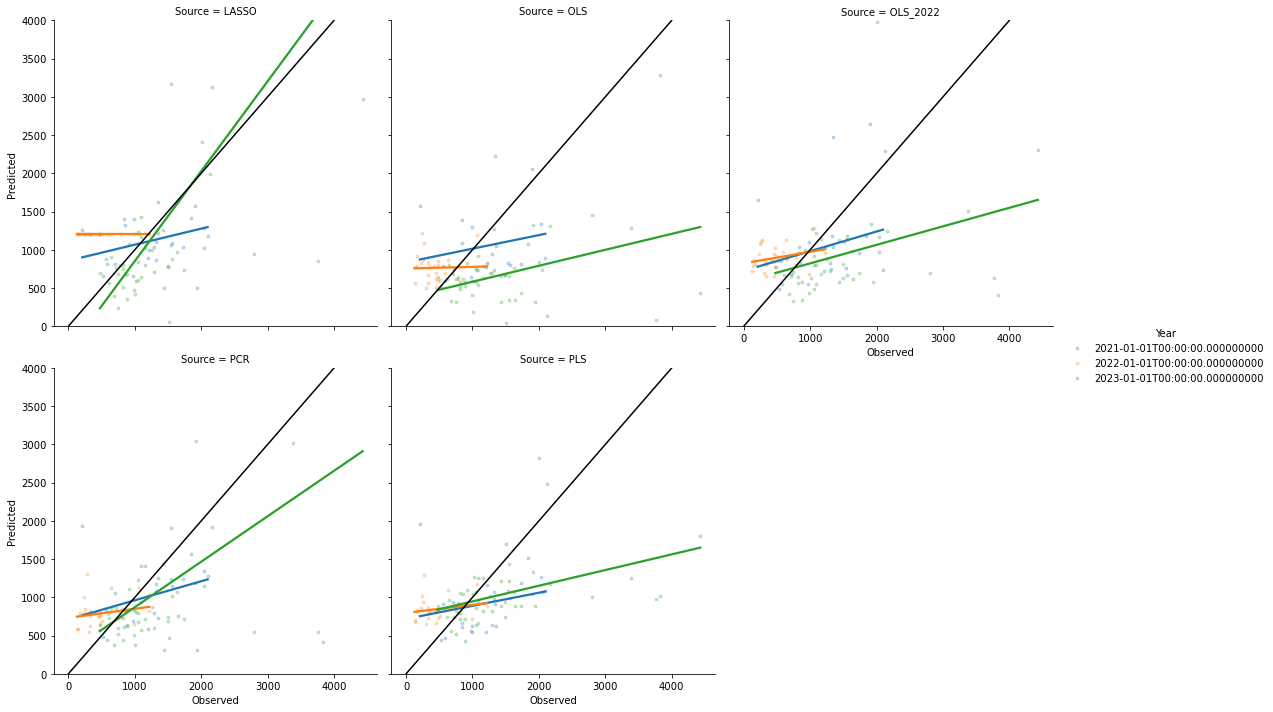

In [46]:
p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', id_col, date_col]).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Year', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

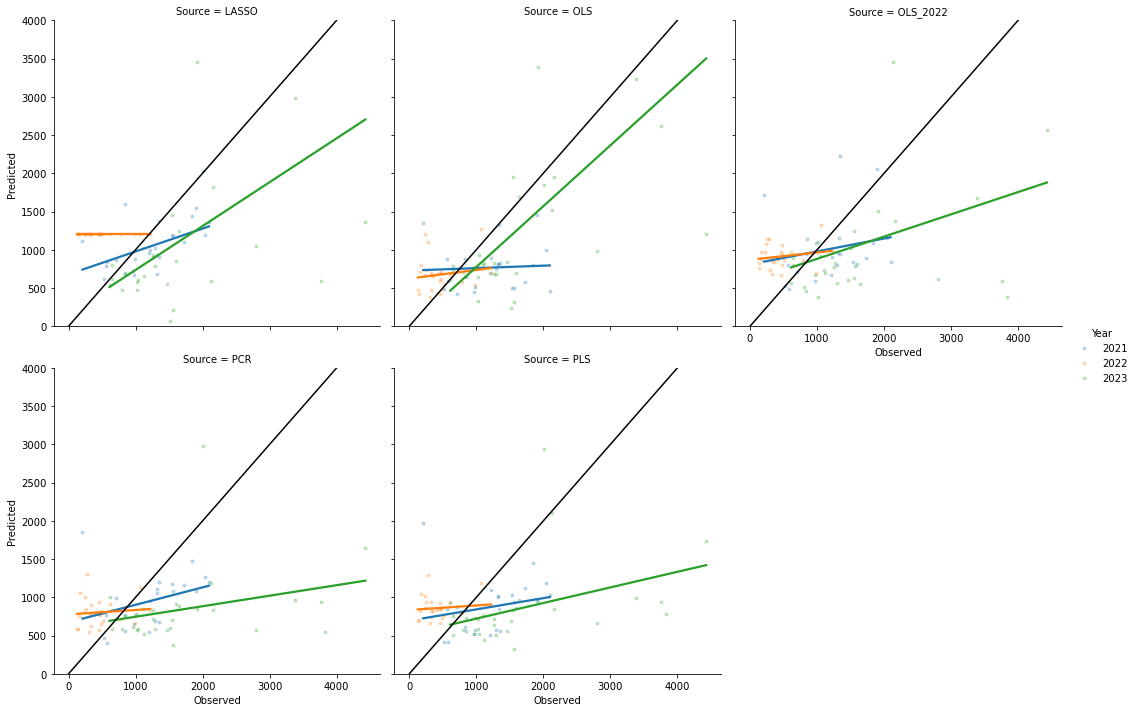

In [38]:
p_pasture = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', date_col]).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Year', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

In [52]:
df_ols = mod_dict['OLS']['formula_df']

In [62]:
df_ols.groupby('year').apply(lambda x: x.sort_values('AIC').head(5))

year numb_vars                                            formula  \
year                                                                        
2021 0  2021         3  biomass_lb_ac ~ psri + tcwi + bai_126 + psri:t...   
     0  2021         3  biomass_lb_ac ~ ndci + tcbi + tcgi + ndci:tcbi...   
     0  2021         3  biomass_lb_ac ~ satvi + tcbi + tcgi + satvi:tc...   
     0  2021         3  biomass_lb_ac ~ ndwi + tcwi + bai_126 + ndwi:t...   
     0  2021         3  biomass_lb_ac ~ ndci + swir1 + bai_126 + ndci:...   
2022 0  2022         3  biomass_lb_ac ~ ndti + ndwi + bai_236 + ndti:n...   
     0  2022         3  biomass_lb_ac ~ tcwi + nir + bai_146 + tcwi:ni...   
     0  2022         3  biomass_lb_ac ~ ndti + satvi + evi + ndti:satv...   
     0  2022         3  biomass_lb_ac ~ ndti + ndci + ndwi + ndti:ndci...   
     0  2022         3  biomass_lb_ac ~ ndti + psri + ndwi + ndti:psri...   
2023 0  2023         3  biomass_lb_ac ~ ndwi + tcwi + bai_126 + ndwi:t...   
     0  2023         3  biomass_lb_ac ~ tcwi + nir + bai_146 + tcwi:ni...   
     0  2023         3  biomass_lb_ac ~ ndwi + blue + nir + ndwi:blue ...   
     0  2023         3  biomass_lb_ac ~ ndwi + green + nir + ndwi:gree...   
     0  2023         3  biomass_lb_ac ~ ndwi + swir2 + bai_126 + ndwi:...   

        R2_adj      AIC  mae_orig_mean                features  
year                                                            
2021 0  0.4823  46.0853         1.2353   [psri, tcwi, bai_126]  
     0  0.4759  46.2187         1.4537      [ndci, tcbi, tcgi]  
     0  0.4716  46.3235         1.3337     [satvi, tcbi, tcgi]  
     0  0.4786  46.4660         1.2622   [ndwi, tcwi, bai_126]  
     0  0.4698  46.6128         1.0523  [ndci, swir1, bai_126]  
2022 0  0.5787  31.1398         0.6807   [ndti, ndwi, bai_236]  
     0  0.5761  32.1322         0.7612    [tcwi, nir, bai_146]  
     0  0.5675  32.8016         0.8538      [ndti, satvi, evi]  
     0  0.5571  33.0969         0.7007      [ndti, ndci, ndwi]  
     0  0.5414  33.7280         0.6888      [ndti, psri, ndwi]  
2023 0  0.5575  30.8077         1.3738   [ndwi, tcwi, bai_126]  
     0  0.5201  33.0606         1.6091    [tcwi, nir, bai_146]  
     0  0.5349  33.0838         1.5296       [ndwi, blue, nir]  
     0  0.5451  33.1077         1.4788      [ndwi, green, nir]  
     0  0.5294  33.4425         1.4411  [ndwi, swir2, bai_126]

In [54]:
df_ols['features'] = df_ols['formula'].apply(lambda x: [f for f in x.split(' ~ ')[-1].split(' + ') if ':' not in f])

In [55]:
from tqdm import tqdm
"""
Calculated weighted relative variable importance for each variable across model types
"""
# set max vars based on where cross-validated metrics stop improving
max_vars = 3

var_names = list(set(df_ols['features'].sum()))

# Calculate decomposed R^2, relative variable importance (RVI) and AIC weights
df_ols_feats_ptn = pd.DataFrame(columns=['year', 'features', 'formula', 'RVI', 'weight'])
for k in df_ols['year'].unique():
    print(k)
    df_ols_sub_tmp = df_ols[(df_ols['year'] == k) &
    (df_ols['numb_vars'] <= max_vars)].copy()
    min_aic = (df_ols_sub_tmp['AIC']*0.001).min()
    df_ols_sub_tmp['AICw'] = [np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)] / \
    np.sum([np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)])
    for f in tqdm(var_names):
        df_ols_sub_f = df_ols_sub_tmp[[f in n for n in df_ols_sub_tmp['formula']]]
        if len(df_ols_sub_f) == 0:
            continue
        else:
            for f_form in df_ols_sub_f['formula']:
                f_form_omitted = re.sub(f + ":[^\+]* \+ ", "",
                                        re.sub(" \+ " + f + ":[^\+]*", "",
                                               re.sub(" \+ " + f + ":.+?(?= |$)", "",
                                                      re.sub(" \+(?<=\+)[^\+]*:" + f, "",
                                                             re.sub("\+ " + f + " (?=\+)", "",
                                                                    re.sub("(?<=~ )" + f + " \+ ", "",
                                                                           f_form))))))

                # print(f_form)
                # print(f_form_omitted)
                RVI_tmp = df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                OVI_tmp = df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                weight_tmp = df_ols_sub_tmp['AICw'][(df_ols_sub_tmp['formula'] == f_form)].values

                df_ols_feats_tmp = pd.DataFrame(dict(year=k,
                                                     features=f,
                                                     formula=f_form,
                                                     RVI=np.mean(RVI_tmp),
                                                     weight=weight_tmp),
                                                index=[0])
                df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])

2021


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


2022


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


2023


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


In [56]:
def feature_type(f):
    if f in ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']:
        return 'Band'
    elif 'bai' in f:
        return 'BAI'
    else:
        return 'Veg. Index'

# calculate weighted relative variable importance (RVIw)
df_ols_feats_ptn['RVIw'] = df_ols_feats_ptn['RVI'] * df_ols_feats_ptn['weight']

# add input variable group field
df_ols_feats_ptn['group'] = df_ols_feats_ptn['features'].apply(feature_type)

# calculate sorted mean RVIw for each feature after summing across each kfold
df_ols_feats_grp = df_ols_feats_ptn.groupby(['year',
                                             'features',
                                             'group'])['RVIw'].sum().reset_index()
df_ols_feats_grp['RVIw_mean'] = df_ols_feats_grp.groupby(['features'])['RVIw'].transform('mean')
df_ols_feats_grp = df_ols_feats_grp.sort_values(['RVIw_mean'], ascending=False).reset_index(drop=True)

In [57]:
df_ols_feats_grp['year'] = df_ols_feats_grp['year'].astype('str')
df_ols_feats_grp['year'] = pd.Categorical(df_ols_feats_grp['year'], 
                                          [str(x) for x in range(min(df_ols_feats_grp['year'].astype(int)),
                                                                 max(df_ols_feats_grp['year'].astype(int))+1)])

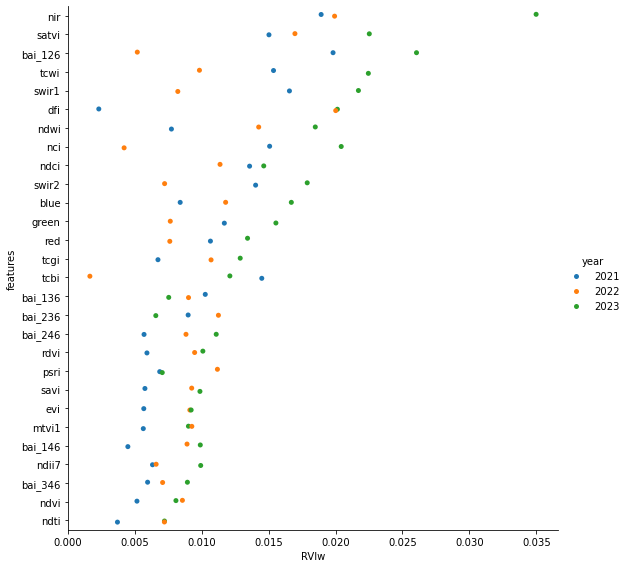

In [58]:
p = sns.catplot(y='features', x='RVIw', hue='year',# hue_order=['Band', 'Veg. Index', 'BAI'],
                orient='h',# palette=sns.color_palette()[6:-1],
                data=df_ols_feats_grp,
                height=8, aspect=1.0)

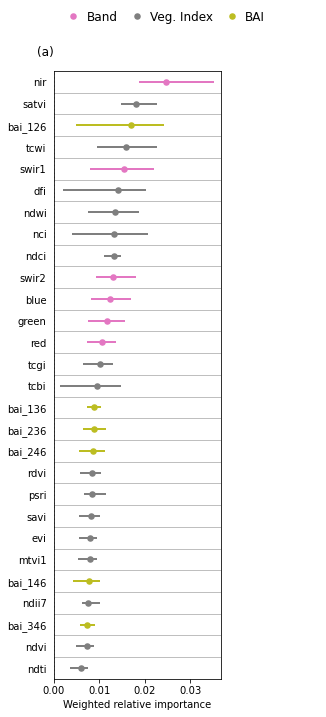

In [59]:
"""
Figure 2: Plot variable importance calculated from all model subsets
"""
font_sml = 10
font_med=12
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(1, 2, 1)
pplot1 = sns.pointplot(y='features', x='RVIw', hue='group', hue_order=['Band', 'Veg. Index', 'BAI'],
                       orient='h', dodge=False, ax=ax1, linestyles='None', linewidth=2.0,
                       palette=sns.color_palette()[6:-1],
                       err_kws=dict(linewidth=2.0),
                       data=df_ols_feats_grp)
ax1.set_ylabel('')
ax1.set_xlabel('Weighted relative importance', fontsize=font_sml)
ax1.get_legend().remove()
#ax1.set_xlim((-0.10, 0.50))
ax1.set_yticks(np.arange(0.5, len(df_ols_feats_grp['features'].unique()) - 1, 1), minor=True)
ax1.grid(which='minor', axis='y')
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
for tic in ax1.yaxis.get_minor_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
ax1.axvline(x=0, color='grey', alpha=0.75, linestyle='dotted')
ax1.tick_params(axis='x', which='major', labelsize=font_sml)
ax1.tick_params(axis='y', which='major', labelsize=font_sml)
ax1.text(x=-0.1, y=1.025, s='(a)', transform=ax1.transAxes, size=font_med)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=font_med,
           columnspacing=0.6, handletextpad=0.1, frameon=False)
plt.tight_layout(w_pad=3.0, rect=(0, 0, 1, 0.95))
if save_results:
    plt.savefig(outDIR_figs + mod_dir_dict[mod_type] + mod_type + '_variable_importance.png', dpi=600,
                bbox_inches='tight', pad_inches=0.2)
    plt.close()

In [63]:
#mod_dict['LASSO']['variable_df']

,Year,Variable,Coef,Coef_abs
0,2021,dfi,0.011593,0.011593
1,2021,ndti,0.082334,0.082334
2,2021,swir2,0.332879,0.332879
3,2021,bai_126,0.003636,0.003636
4,2021,dfi psri,0.074085,0.074085
5,2021,ndti nir,0.049604,0.049604
6,2021,nci nir,0.117395,0.117395
7,2021,psri bai_136,0.143000,0.143000
8,2021,psri bai_346,0.053929,0.053929
9,2021,ndwi swir1,0.114821,0.114821


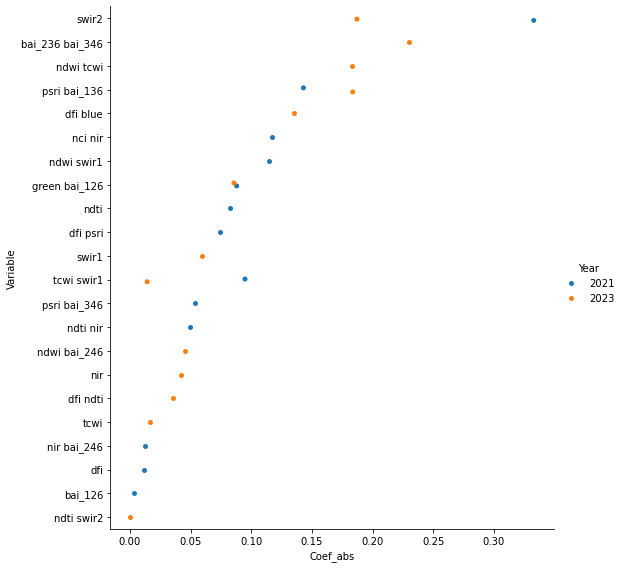

In [39]:
df_lasso_coefs = mod_dict['LASSO']['variable_df']
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
df_lasso_coefs_ranked = df_lasso_coefs.groupby('Variable')['Coef_abs'].mean().sort_values(ascending=False)
df_lasso_coefs['Variable'] = pd.Categorical(df_lasso_coefs['Variable'], categories=df_lasso_coefs_ranked.index.values)
p = sns.catplot(df_lasso_coefs, x='Coef_abs', y='Variable', hue='Year', height=8, aspect=1.0, orient='h')
#for ax in p.axes.flatten():
#    ax.tick_params(axis='x', rotation=90)

In [41]:
df_lasso_coefs.groupby('Variable')['Coef'].count().sort_values(ascending=False)

Variable
swir2              2
psri bai_136       2
green bai_126      2
tcwi swir1         2
dfi blue           1
nci nir            1
bai_126            1
dfi                1
nir bai_246        1
tcwi               1
dfi ndti           1
nir                1
ndwi bai_246       1
ndti nir           1
psri bai_346       1
bai_236 bai_346    1
swir1              1
dfi psri           1
ndti               1
ndwi tcwi          1
ndwi swir1         1
ndti swir2         1
Name: Coef, dtype: int64

In [42]:
df_lasso_coefs.groupby('Year')['Coef'].count()

Year
2021    13
2023    13
Name: Coef, dtype: int64

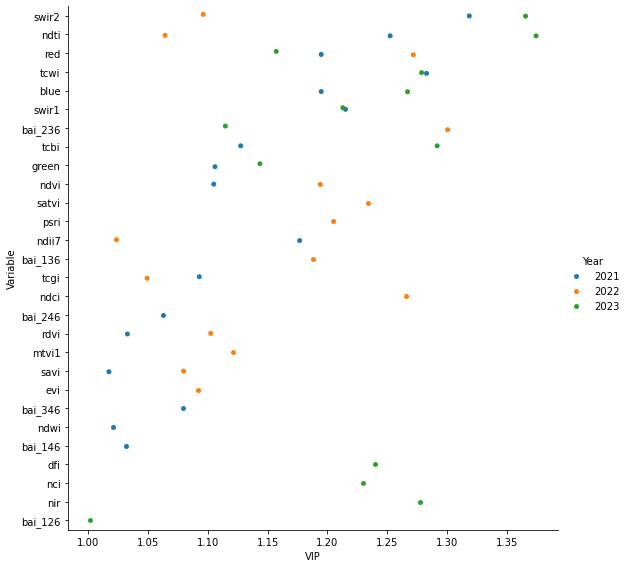

In [43]:
df_vip = mod_dict['PLS']['variable_df']
df_vip_ranked = df_vip.groupby('Variable')['VIP'].mean().sort_values(ascending=False)
df_vip['Variable'] = pd.Categorical(df_vip['Variable'], categories=df_vip_ranked.index.values)
df_vip_top = df_vip[df_vip['VIP'] > 1.0].copy()
df_vip_top['Variable'] = df_vip_top['Variable'].cat.remove_unused_categories()
p = sns.catplot(df_vip_top, x='VIP', y='Variable',  hue='Year', height=8, aspect=1.0, orient='h')

In [44]:
df_vip[df_vip['VIP'] > 1.0].groupby('Variable')['VIP'].count().sort_values(ascending=False)

Variable
swir2      3
red        3
ndti       3
green      2
savi       2
rdvi       2
ndii7      2
ndvi       2
tcgi       2
tcbi       2
bai_236    2
swir1      2
blue       2
tcwi       2
bai_346    1
nir        1
nci        1
dfi        1
bai_146    1
ndwi       1
mtvi1      1
evi        1
satvi      1
bai_246    1
ndci       1
bai_136    1
psri       1
bai_126    1
Name: VIP, dtype: int64

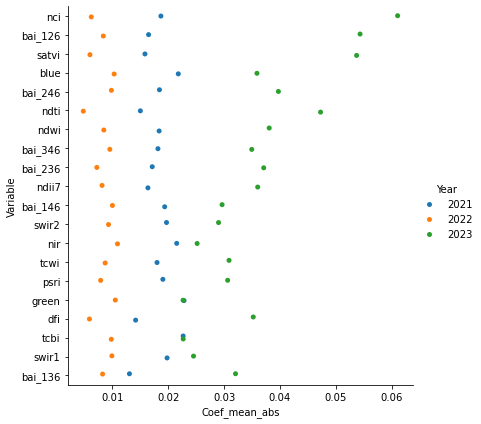

In [45]:
df_pcr_coefs = mod_dict['PCR']['variable_df']
pcr_coefs_abs_mean = df_pcr_coefs.groupby(['Year', 'Variable']).apply(lambda x: np.mean(np.abs(x), axis=1))
pcr_coefs_abs_mean.name = 'Coef_mean_abs'
df_pcr_coefs_mean = pcr_coefs_abs_mean.reset_index()

pcr_vars_mean_ranked = df_pcr_coefs_mean.groupby('Variable')['Coef_mean_abs'].mean().sort_values(ascending=False)
df_pcr_coefs_mean['Variable'] = pd.Categorical(df_pcr_coefs_mean['Variable'], categories=pcr_vars_mean_ranked.index.values)

df_pcr_coefs_mean_top20 = df_pcr_coefs_mean[df_pcr_coefs_mean['Variable'].isin(pcr_vars_mean_ranked.head(20).index.values)].copy()
df_pcr_coefs_mean_top20['Variable'] = df_pcr_coefs_mean_top20['Variable'].cat.remove_unused_categories()

p = sns.catplot(df_pcr_coefs_mean_top20,
                x='Coef_mean_abs', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_svr_pi = mod_dict['SVR']['variable_df']
df_svr_pi_ranked = df_svr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_svr_pi['Variable'] = pd.Categorical(df_svr_pi['Variable'], categories=df_svr_pi_ranked.index.values)
p = sns.catplot(df_svr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_rf_pi = mod_dict['RF']['variable_df']
df_rf_pi_ranked = df_rf_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_rf_pi['Variable'] = pd.Categorical(df_rf_pi['Variable'], categories=df_rf_pi_ranked.index.values)
p = sns.catplot(df_rf_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_gbr_pi = mod_dict['GBR']['variable_df']
df_gbr_pi_ranked = df_gbr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_gbr_pi['Variable'] = pd.Categorical(df_gbr_pi['Variable'], categories=df_gbr_pi_ranked.index.values)
p = sns.catplot(df_gbr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', row='Year', col_order=['LASSO', 'PLS', 'PCR', 'RF', 'SVR', 'GBR'],
               hue='Season', ci=None, order=1,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes.flatten():
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

In [47]:
param_dfs = {}
for k in mod_dict:
    if 'OLS' in k:
        continue
    else:
        for idx, yr in enumerate(mod_dict[k]['tune_results']):
            if idx == 0:
                param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results'][yr]['params']]))
                param_dfs[k] = pd.DataFrame(columns=['Model', 'Year', 'Best', 'MAPE', 'MSE', 'R2', 'R2_train'] + param_names)
            df_tmp = pd.DataFrame({'Model': k,
                                   'Year': yr,
                                   'Best': 0,
                                   'MAPE': mod_dict[k]['tune_results'][yr]['mean_test_MAPE'],
                                   'MSE': mod_dict[k]['tune_results'][yr]['mean_test_MSE'],
                                   'R2': mod_dict[k]['tune_results'][yr]['mean_test_R2'],
                                   'R2_train': mod_dict[k]['tune_results'][yr]['mean_train_R2']})
            for p in param_names:
                df_tmp[p] = mod_dict[k]['tune_results'][yr]['param_' + p].data
            idx_best = mod_dict[k]['tune_results'][yr]['rank_test_MAPE'].argmin()
            df_tmp.loc[idx_best, 'Best'] = 1
            param_dfs[k] = pd.concat([param_dfs[k], df_tmp])

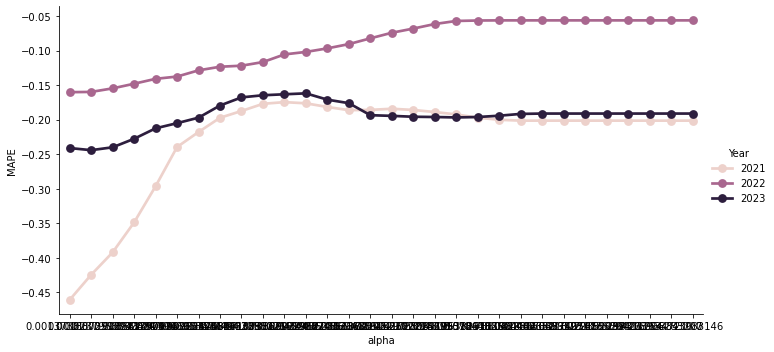

In [48]:
sns.catplot(x='alpha', y='MAPE', data=param_dfs['LASSO'], hue='Year', kind='point', aspect=2)

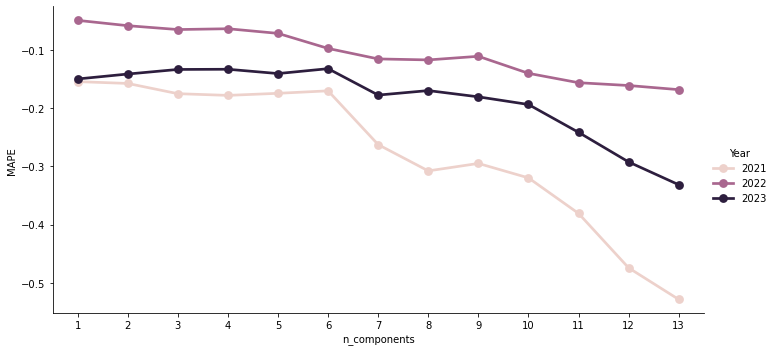

In [49]:
sns.catplot(x='n_components', y='MAPE', data=param_dfs['PLS'], hue='Year', kind='point', aspect=2)

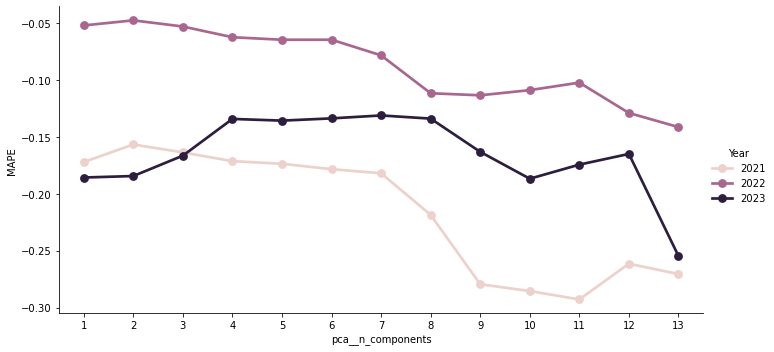

In [50]:
sns.catplot(x='pca__n_components', y='MAPE', data=param_dfs['PCR'], hue='Year', kind='point', aspect=2)

In [51]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

KeyError: 'RF'

In [ ]:
sns.catplot(x='max_samples', y='MSE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='n_estimators', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
param_dfs['RF']['max_features'][param_dfs['RF']['max_features'].isnull()] = 'None'
sns.catplot(x='max_features', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='ccp_alpha', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='gamma', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='C', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='learning_rate', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='max_features', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='n_estimators', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)